Vers la mi-janvier, j'ai encadré un groupe d'étudiants qui se penchaient sur les habitudes de transports dans la Communauté de communes du Kreiz-Breizh, la seule hyper-rurale de Bretagne. Ils ont pour cela manipulé des **fichiers de mobilité professionnelle fournis par l'INSEE**.

Le potentiel de ces bases de données est tellement vaste que j'ai voulu m'en servir pour mesurer **la pratique du vélo au sein de la Métropole de Lyon**. Un travail équivalent a été fait pour Rue89 Strasbourg, avec des opérations semblables.

L'objectif est de préparer des fichiers json **digérables par la bibliothèque de visualisation D3js**. Un avantage de se spécialiser dans les données est d'être en mesure de les transformer à ses propres contraintes, et j'espère que ce calpein en fournira une bonne illustration.

On se penchera dont sur les fichiers de mobilité professionnelle cru [2018](https://www.insee.fr/fr/statistiques/5395749?sommaire=5395764), [2013](https://www.insee.fr/fr/statistiques/2409494?sommaire=2409559), et [2008](https://www.insee.fr/fr/statistiques/2408676?sommaire=2409062). Ces fichiers sont gros, et on va partir du principe que les csv correspondants sont rangés dans un dossier "mopro" attenant à ce calepin.

Dès ces prérequis remplis, on peut importer :

In [1]:
import json
import requests
import geopandas as gpd
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from bs4 import BeautifulSoup

# Premières sélections et transformation en 2018

On va se pencher sur un premier fichier qui servira à une cartographie interactive par mode de transport, dans cet esprit : 

![carte_mopro_eurom](images\\mlmopro_velo.jpg)

Le début de l'histoire est connue, avec affectation d'une DataFrame à partir du fichier des mobilités de 2018 :

In [2]:
mopro_2018=pd.read_csv(r"mopro\\FD_MOBPRO_2018.csv",sep=";",low_memory=False)
mopro_2018.tail()

,COMMUNE,ARM,DCFLT,DCLT,AGEREVQ,CS1,DEROU,DIPL,EMPL,ILT,...,REGION,REGLT,SEXE,STAT,STOCD,TP,TRANS,TYPL,TYPMR,VOIT
7932890,97424,ZZZZZ,99999,97424,35,4,0,3,16,1,...,4,04,1,10,10,1,5,1,11,1
7932891,97424,ZZZZZ,99999,97424,30,5,0,14,13,1,...,4,04,1,10,10,2,5,1,20,1
7932892,97424,ZZZZZ,99999,97424,20,5,0,14,15,1,...,4,04,2,10,10,2,5,1,44,0
7932893,97424,ZZZZZ,99999,97424,75,2,0,3,22,1,...,4,04,1,22,10,2,1,1,20,0
7932894,97424,ZZZZZ,99999,97424,45,2,0,16,21,1,...,4,04,1,21,10,1,1,1,32,2


Il y a un nombre conséquent de colonnes qui ne vont pas servir, et dont on peut donc se passer afin de gagner en clarté. Le plus simple est de faire notre marché après avoir consulté [le dictionnaire des variables fourni par l'INSEE](https://www.insee.fr/fr/statistiques/5395749?sommaire=5395764#dictionnaire).

Dans notre cas, nous allons retenir :
* la commune de résidence (COMMUNE)
* l'arrondissement municipal (ARM). Lyon faisant partie de trio du villes françaises découpables par arrondissement, on va en profiter sans vergogne
* la commune de travail (DCLT)
* la catégorie socio-professionnelle (CS1)
* le poids individuel (IPONDI). On y reviendra
* le mode de transport (TRANS)

Certains noms ne sont pas clairs, on va donc **préparer une table de correspondance** en utilisant le dictionnaire suivant :

In [3]:
reno_col={"COMMUNE":"insee_residence","ARM":"arrondissement","DCLT":"insee_travail","CS1":"csp","IPONDI":"pindi","TRANS":"mode_transport"}

Désormais, on peut renommer les colonnes et ne retenir ensuite que celles qui nous intéressent. Traduction : **les valeurs présentes dans le dictionnaire reno_col**.

On va, avant chaque taillage d'envergure, **faire une copie de la DF originelle**. Cela évitera de devoir recharger un fichier très volumineux, et est une sécurité en cas de fausse manipulation.

Le plan est donc le suivant : copie, renommage des colonnes cibles, et retenue de ces dernières uniquement :

In [4]:
mopro_t2018=mopro_2018.copy()
mopro_t2018.rename(columns=reno_col, inplace=True)
mopro_t2018=mopro_t2018[reno_col.values()]
mopro_t2018.tail()

,insee_residence,arrondissement,insee_travail,csp,pindi,mode_transport
7932890,97424,ZZZZZ,97424,4,5.208902,5
7932891,97424,ZZZZZ,97424,5,5.134249,5
7932892,97424,ZZZZZ,97424,5,4.846184,5
7932893,97424,ZZZZZ,97424,2,5.134249,1
7932894,97424,ZZZZZ,97424,2,5.134249,1


Il est temps de se pencher sur **[la fameuse colonne de poids individuel](https://www.insee.fr/fr/information/2383243)**, appelée pindi dans la DataFrame ci-dessous. En préambule, je tiens à remercier Victor Alexandre [dont les #DataTaff](https://twitter.com/humeursdevictor/status/1491668662364876800) m'ont grandement aidé à appréhender cette donnée.

Pour le résumer vite, **chaque ligne de la BDD ne correspond pas à une personne**, elle est pondérée statistiquement. Pour avoir des effectifs complets, il faut additionner les valeurs de cette colonne. On peut faire quelques observations en visualisant son histogramme :

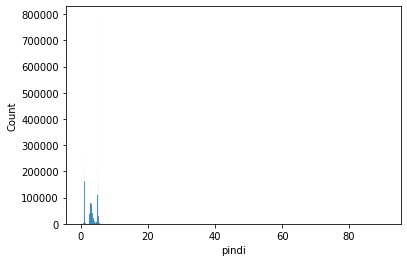

In [5]:
sns.histplot(data=mopro_t2018, x="pindi");

Premier constat : [la distribution normale](https://fr.wikipedia.org/wiki/Loi_normale) est loin, très loin. On a aussi très peu de valeurs extrêmes allant à près de 100 pour les maximales, et un important regroupement de poids entre 0 et 10.

La **fonction pandas describe** va apporter **quelques informations supplémentaires** :

In [6]:
mopro_t2018["pindi"].describe()

count    7.932895e+06
mean     3.408104e+00
std      1.454358e+00
min      1.666683e-02
25%      2.681830e+00
50%      3.267721e+00
75%      4.983474e+00
max      9.083286e+01
Name: pindi, dtype: float64

Sur ces presque 8 millions d'entrée, la moyenne et la médiane sont assez proches, respectivement à 3,41 et 3,27. Le poids individuel maximum s'établit à 90,83 et le minimum à 0,017. Bref, **on n'est pas sur un schéma une ligne=un individu**.

Maintenant, on va faire des sélections de lignes à partir de codes INSEE. Ceux de la Métropole de Lyon sont [dispos sur Wikipedia](https://fr.wikipedia.org/wiki/M%C3%A9tropole_de_Lyon), on va donc activer un petit script de scraping afin de récupérer les codes et les noms de villes, comme ceci :

In [7]:
# il suffit juste de paramétrer une liste vide qui va abriter l'ensemble des noms
ml_insee=[]
ml_nom=[]
url = "https://fr.wikipedia.org/wiki/M%C3%A9tropole_de_Lyon"
url = requests.get(url)

soupe = BeautifulSoup(url.text, "lxml")
tableau = soupe.find("table", {"class":"wikitable sortable"})
lignes = tableau.findAll("tr")
# à chaque ligne, si les infos d'une ville existe, on sélectionne le deuxième élément pour le glisser dans notre liste
for ligne in lignes:
    info_ville = ligne.findAll("td")
    if info_ville:
        ml_nom.append(info_ville[0].get_text().replace("\n",""))
        ml_insee.append(info_ville[1].get_text().replace("\n",""))

print(len(ml_insee),len(ml_nom))

59 59


Et maintenant ? On va réserver la DF précédente avec une copie, puis **formater les colonnes** insee_residence et insee_travail **en chaînes de caractères** :

In [8]:
mopro_ml18=mopro_t2018.copy()
mopro_ml18["insee_residence"]=mopro_ml18["insee_residence"].astype(str)
mopro_ml18["insee_travail"]=mopro_ml18["insee_travail"].astype(str)

Cette conversion va rendre possible la sélection sur les communes de la Métropole de Lyon : **la liste ml_insee étant composée de 59 chaînes de caractères**, on peut filtrer les colonnes bien formatées grâce à la fonction isin.

En gros, si une valeur présente dans une colonne se retrouve dans la liste de référence, on retient sa ligne, et exit le reste :

In [9]:
mopro_ml18=mopro_ml18[mopro_ml18["insee_residence"].isin(ml_insee)]
mopro_ml18=mopro_ml18[mopro_ml18["insee_travail"].isin(ml_insee)].reset_index(drop=True)
# une fois que c'est fait, on vire la colonne insee_travail qui ne sera pas considérée dans le reste de l'analyse
mopro_ml18=mopro_ml18[["insee_residence","arrondissement","pindi","mode_transport"]]
mopro_ml18.tail()

,insee_residence,arrondissement,pindi,mode_transport
94417,69296,ZZZZZ,5.064364,5
94418,69296,ZZZZZ,5.169799,5
94419,69296,ZZZZZ,5.064364,1
94420,69296,ZZZZZ,5.064364,1
94421,69296,ZZZZZ,5.277429,5


Plus de 94 000 lignes retenues sur les huit millions de la BDD initiale. On va maintenant extraire les valeurs uniques de la colonne "arrondissement" :

In [10]:
mopro_ml18["arrondissement"].unique()

array(['ZZZZZ', '69381', '69382', '69383', '69384', '69385', '69386',
       '69387', '69388', '69389'], dtype=object)

"ZZZZZ" et les neufs arrondissements de Lyon ressortent. **Ces "ZZZZZ" correspondent-ils aux insee_residence autres que Lyon ?**

Pour le vérifier, il suffit de bien paramétrer une requête sur mopro_ml18, avec :
* un filtre sur les valeurs non "ZZZZZ" dans la Serie pandas "arrondissement"
* un affichage des valeurs uniques de "insee_residence" après cet écrémage. Si notre hypothèse est confirmée, il ne devrait y avoir que "69123" (le code INSEE de Lyon)

Et en bon Python, cela se passe comme suit :

In [11]:
mopro_ml18[mopro_ml18["arrondissement"]!="ZZZZZ"]["insee_residence"].unique()

array(['69123'], dtype=object)

¡Estupendo! On peut aussi vérifier que la proposition inverse est vrai : est-ce que, pour les lignes où insee_residence correspond à "69123", on trouve un "arrondissement" égale à "ZZZZZ" ?

In [12]:
mopro_ml18[mopro_ml18["insee_residence"]=="69123"]["arrondissement"].isin(["ZZZZZ"]).unique()

array([False])

C'est faux ! Dit autrement, aucune ligne concernant la ville de Lyon est associée à un arrondissement égale à "ZZZZZ".

Ultime vérif : si tout colle, on devrait avoir le même nombre de lignes pour lesquelles le code INSEE de résidence est égal à "69123" et la colonne "arrondissement" est différente de "ZZZZZ" :

In [13]:
print(len(mopro_ml18[mopro_ml18["insee_residence"]=="69123"]))
print(len(mopro_ml18[mopro_ml18["arrondissement"]!="ZZZZZ"]))

24367
24367


24 367 lignes des deux côtés, bien semblables. Pourquoi toutes ces vérifications ? Parce qu'on va modifier la DataFrame afin de **remplacer le code commune de la ville découpée par arrondissements par un arrondissement**.

Pour ce faire, nous allons **coder une fonction** qui va :
* parcourir une DataFrame de référence ligne par ligne. Chaque ligne sera décrite sous la forme d'un dictionnaire
* **si on tombe sur une valeur de remplacement dans une colonne de référence** (par exemple : ce qui n'est pas "ZZZZZ" dans arrondissement), on remplace la valeur d'une colonne cible (dans notre cas insee_residence)
* on retourne le dico modifié ou non dans une liste déclarée au début
* à la toute fin de la fonction, **on transforme cette liste de dictionnaires en DataFrame** renvoyée en résultat

Quelques lignes de Python, et l'affaire est réglée :

In [14]:
def remplacement_unique(DF:pd.core.frame.DataFrame,col_ref:str,col_cible:str,val_tri:list):
    """
        Cette fonction va parcourir une DataFrame ligne par ligne et considérée une colonne de référence.
        Si une valeur qui n'est pas dans une liste de tri est trouvée, on remplace la valeur d'une colonne cible est remplacée.
        Exemple : remplacer la commune de Lyon par l'arrondissement indiqué dans une autre colonne.
    """
    l_dico=[]
    for i, d in DF.iterrows():
        if d[col_ref] not in val_tri:
            d[col_cible]=d[col_ref]
            l_dico.append(d)
        else:
            l_dico.append(d)
    return pd.DataFrame.from_dict(l_dico, orient="columns")

Avant de tester la fonction, affichons le nombre de codes INSEE uniques pour la colonne de résidencce :

In [15]:
print(len(mopro_ml18["insee_residence"].unique()))

59


59, ça colle bien à la liste importée depuis Wikipedia. Si tout va bien, après le passage de la fonction remplacement_unique, on devrait en avoir 67 (59-Lyon+les neuf arrondissements).

On teste ? On teste !

In [16]:
test=remplacement_unique(mopro_ml18,"arrondissement","insee_residence",["ZZZZZ"])
len(test["insee_residence"].unique())

67

C'est conforme. On peut également vérifier que, pour les lignes où arrondissement n'est pas "ZZZZZ", on a dans la colonne insee_residence un arrondissement lyonnais, et non plus le 69123 :

In [17]:
list(test[test["arrondissement"]!="ZZZZZ"]["insee_residence"].unique())

['69381',
 '69382',
 '69383',
 '69384',
 '69385',
 '69386',
 '69387',
 '69388',
 '69389']

Tout ça pour remplacer désormais la variable mopro_m18 par le résultat de la fonction remplacement_unique :

In [18]:
mopro_ml18=remplacement_unique(mopro_ml18,"arrondissement","insee_residence",["ZZZZZ"])
mopro_ml18=mopro_ml18[["insee_residence","pindi","mode_transport"]]
mopro_ml18.tail()

,insee_residence,pindi,mode_transport
94417,69296,5.064364,5
94418,69296,5.169799,5
94419,69296,5.064364,1
94420,69296,5.064364,1
94421,69296,5.277429,5


À présent, on va se pencher sur la colonne mode_transport. Il serait beaucoup plus clair **d'avoir les libellés de chaque transport** plutôt qu'un identifiant. 

Encore une fois, on va utiliser **un dictionnaire de correspondance**, cette fois-ci pour transformer la colonne mode_transport via la fonction map() (et après l'avoir formatée en chaînes de cara) :

In [19]:
corres_transport={"1":"aucun","2":"à pied","3":"vélo","4":"deux-roues motorisé","5":"voiture, camion ou fourgonnette","6":"transports en commun","Z":"sans objet"}
mopro_ml18["mode_transport"]=mopro_ml18["mode_transport"].astype(str)
mopro_ml18["mode_transport"]=mopro_ml18["mode_transport"].map(corres_transport)
mopro_ml18.iloc[-6:]

,insee_residence,pindi,mode_transport
94416,69296,5.169799,"voiture, camion ou fourgonnette"
94417,69296,5.064364,"voiture, camion ou fourgonnette"
94418,69296,5.169799,"voiture, camion ou fourgonnette"
94419,69296,5.064364,aucun
94420,69296,5.064364,aucun
94421,69296,5.277429,"voiture, camion ou fourgonnette"


Il est temps d'enfin considérer la colonne pindi. Pour commencer, on va additionner tous les poids individuels qui la composent afin d'avoir l'effectif complet :

In [20]:
round(mopro_ml18["pindi"].sum())

267553

267 553 actifs résidant et travaillant dans la Métropole de Lyon, soit **environ 20% du 1,4 million d'habitants qu'elle compte**. Cette proportion peut paraître faible, et on rappellera qu'il faut notammer retrancher de la population :
* les mineurs de moins de 15 ans
* les retraités
* les étudiants
* les personnes sans emploi
* les personnes résidant dans la Métropole de Lyon mais travaillant à l'extérieur de celle-ci

Notre sélection (résidents et actifs au sein de la Métropole de Lyon) **tend à favoriser certains transports par rapport à d'autres**. Il est fort à parier qu'en considérant les résidents travaillant hors de la métropole les chiffres de la voiture ou des transports en commun (notamment le train) serait plus important. Ce n'est pas un problème, il suffit juste d'être au clair sur cette sélection dans l'article.

Par simple curiosité, visualisons la répartition de ces poids individuels :

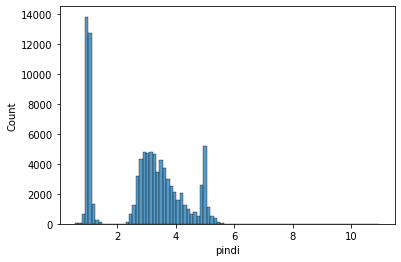

In [21]:
sns.histplot(data=mopro_ml18, x="pindi");

En résumé, en comparaison de la BDD initiale :
* des extrêmes moins marqués, avec un maximum autour de 12
* des pics notables aux alentours de 1 (sûrement beaucoup de célibataires) et de 5
* une cloche assez symétrique de 2 à 5 sans doute liée aux plupart des familles.

On va regrouper les effectifs par mode de transport grâce à la [fonction groupby()](https://pandas.pydata.org/docs/reference/api/pandas.DataFrame.groupby.html). Cela se passe comme suit :

In [22]:
mopro_ml18=mopro_ml18.groupby(by=["insee_residence","mode_transport"]).sum().reset_index()
mopro_ml18["pindi"]=round(mopro_ml18["pindi"])
mopro_ml18["pindi"]=mopro_ml18["pindi"].astype(int)
mopro_ml18.rename(columns={"pindi":"effectif"},inplace=True)
mopro_ml18.iloc[-6:]

,insee_residence,mode_transport,effectif
381,69389,aucun,1
382,69389,deux-roues motorisé,98
383,69389,transports en commun,2370
384,69389,"voiture, camion ou fourgonnette",3804
385,69389,vélo,142
386,69389,à pied,123


Petite vérif au passage afin d'être sûr qu'il n'y ait pas eu d'erreur de calcul :

In [23]:
mopro_ml18["effectif"].sum()

267557

Quatre personnes en trop, soit une goutte d'eau dans un océan. On continue avec **l'ajout d'une colonne de contextualisation, qui stockera le nom des communes**.

Pour rappel, on a récupéré lors de la phase de scraping les communes de la Métropole de Lyon. Il va falloir :
* retrancher des tableaux ml_insee et ml_nom Lyon (respectivement "69123" et "Lyon(siège") 
* ajouter les arrondissement. Côté INSEE, c'est simple : ils commencent par "6938" et se terminent par le numéro d'arrondissement. Côté noms ça l'est tout autant, en prévoyant juste le cas particulier du premier arrondissement

In [24]:
# on réserve les communes strictes de la métropole pour plus tard !
# attention au [:] pour bien entériner une copie de metropole_lyon (et non une référence)

# et on crée une liste avec les codes INSEE de chaque arrondissement lyonnais
insee_lyon=[]
com_lyon=[]
for i in range(1,10):
    insee_lyon.append("6938"+str(i))
    if i!=1:
        com_lyon.append(str(i)+"e arrondissement de Lyon")
    else:
        com_lyon.append("1er arrondissement de Lyon")

ml_arr=ml_insee[:]
ml_arr.remove("69123")
ml_arr.extend(insee_lyon)

ml_arrn=ml_nom[:]
ml_arrn.remove("Lyon(siège)")
ml_arrn.extend(com_lyon)

print(len(ml_arr), len(ml_arrn))

67 67


Grâce à cela, on va créer une table de correspondance grâce à **[une bonne vieille compréhension de dictionnaire](https://www.datacamp.com/community/tutorials/python-dictionary-comprehension)** :

In [25]:
dic_ml={k:v.split("(")[0] for k,v in zip(ml_arr, ml_arrn)}
# si vous voulez afficher l'ensemble du dico, décommentez la ligne suivante
#dic_ml

La suite est connue, on crée une nouvelle colonne en mappant la colonne insee_residence à partir des clés/valeurs de dic_ml :

In [26]:
mopro_ml18["residence"]=mopro_ml18["insee_residence"].map(dic_ml)
mopro_ml18=mopro_ml18[["residence","insee_residence","mode_transport","effectif"]]
mopro_ml18.iloc[-6:]

,residence,insee_residence,mode_transport,effectif
381,9e arrondissement de Lyon,69389,aucun,1
382,9e arrondissement de Lyon,69389,deux-roues motorisé,98
383,9e arrondissement de Lyon,69389,transports en commun,2370
384,9e arrondissement de Lyon,69389,"voiture, camion ou fourgonnette",3804
385,9e arrondissement de Lyon,69389,vélo,142
386,9e arrondissement de Lyon,69389,à pied,123


À partir de là, le fin du fin serait d'avoir une ligne par commune. Et pour cela, l'étape obligée s'appelle "tableau croisé dynamique".

Cela se code très facilement avec pandas grâce à la fonction pivot_table. Pour rappel, **il faut prendre en compte trois paramètres** :
* les **index**, c'est-à-dire les **colonnes qui vont rester figées**. Dans notre cas ce seront resident et insee_residence car on veut une ligne et une seule pour chacune de leur valeur
* une **colonne dont chaque valeur unique va être transformée en colonne à part**. Ici ce sera mode_transport, et on aura à l'arrivée une colonne pour le vélo, la voiture, etc
* une **colonne de valeurs à répartir entre les nouvelles colonnes**. Par ici c'est limpide, ce sera effectif

In [27]:
mopro_ml18=mopro_ml18.pivot_table(index=["residence","insee_residence"], columns=["mode_transport"], values=["effectif"])
mopro_ml18.columns=mopro_ml18.columns.map('_'.join)
mopro_ml18=mopro_ml18.reset_index()
mopro_ml18.tail()

,residence,insee_residence,effectif_aucun,effectif_deux-roues motorisé,effectif_transports en commun,"effectif_voiture, camion ou fourgonnette",effectif_vélo,effectif_à pied
62,Vaulx-en-Velin,69256,348.0,67.0,2469.0,6499.0,220.0,869.0
63,Vernaison,69260,50.0,5.0,55.0,936.0,NaN,56.0
64,Villeurbanne,69266,1676.0,350.0,10744.0,14539.0,2259.0,4760.0
65,Vénissieux,69259,510.0,117.0,2960.0,8055.0,218.0,882.0
66,Écully,69081,396.0,81.0,472.0,2514.0,59.0,305.0


Quelques remarques :
* 67 lignes dans la DF, c'est conforme à ce qu'on attendait
* **certaines cellules contiennent des Not a Number** (NaN). Cela arrive quand on n'a aucune valeur à fournir pour un mode de transport

Pandas intègre une **fonction de remplissage automatique**, [fillna()](https://pandas.pydata.org/docs/reference/api/pandas.DataFrame.fillna.html). On va remplacer grâce à elle **les NaN par des zéros**, et également : 
* reconvertir les colonnes d'effectifs en nombres entiers
* les renommer, pour l'hygiène

In [28]:
mopro_ml18.fillna(0,inplace=True)
for c in ["effectif_aucun","effectif_deux-roues motorisé","effectif_transports en commun","effectif_voiture, camion ou fourgonnette","effectif_vélo","effectif_à pied"]:
    mopro_ml18[c]=mopro_ml18[c].astype(int)
mopro_ml18.rename(columns={"effectif_aucun":"aucun","effectif_deux-roues motorisé":"deux-roues","effectif_transports en commun":"tec","effectif_voiture, camion ou fourgonnette":"voiture","effectif_vélo":"velo","effectif_à pied":"pied"}, inplace=True)
mopro_ml18.tail()

,residence,insee_residence,aucun,deux-roues,tec,voiture,velo,pied
62,Vaulx-en-Velin,69256,348,67,2469,6499,220,869
63,Vernaison,69260,50,5,55,936,0,56
64,Villeurbanne,69266,1676,350,10744,14539,2259,4760
65,Vénissieux,69259,510,117,2960,8055,218,882
66,Écully,69081,396,81,472,2514,59,305


On va faire vite, avec la création d'une nouvelle colonne d'ensemble qui additionne les colonnes de transport :

In [29]:
mopro_ml18["ensemble"]=mopro_ml18["aucun"]+mopro_ml18["deux-roues"]+mopro_ml18["tec"]+mopro_ml18["voiture"]+mopro_ml18["velo"]+mopro_ml18["pied"]
mopro_ml18.tail()

,residence,insee_residence,aucun,deux-roues,tec,voiture,velo,pied,ensemble
62,Vaulx-en-Velin,69256,348,67,2469,6499,220,869,10472
63,Vernaison,69260,50,5,55,936,0,56,1102
64,Villeurbanne,69266,1676,350,10744,14539,2259,4760,34328
65,Vénissieux,69259,510,117,2960,8055,218,882,12742
66,Écully,69081,396,81,472,2514,59,305,3827


On peut aussi (et ça aura son importance lors d'une éventuelle factorisation) **utiliser le module Numpy** pour additionner le tout sans avoir à écrire enn dur les colonnes à additionner une par une. 

Par exemple, en créant un premier array Numpy puis contenant six tableaux de soixante-sept entrées et en additionnant par sextuor d'entrées.

Pour le faire vite :

In [30]:
ensemble_np=np.array([mopro_ml18[c] for c in ["aucun","deux-roues","tec","voiture","velo","pied"]])
ensemble_np=[np.sum(ensemble_np[:,i]) for i in range(len(ensemble_np[0]))]
mopro_ml18["ensemble_np"]=list(ensemble_np)
set(list(mopro_ml18["ensemble_np"]==mopro_ml18["ensemble"]))

{True}

Parfait, retour à la situation initiale :

In [31]:
mopro_ml18=mopro_ml18[["residence","insee_residence","aucun","deux-roues","tec","voiture","velo","pied","ensemble"]]

Deux vérifications, à ce stade. En premier lieu, s'assurer que la somme des effectifs est conforme à ce qui avait été observé avant :

In [32]:
mopro_ml18["ensemble"].sum()

267557

Aucun problème de ce côté-là. On peut aussi trier les villes par la colonne ensemble, et vérifier que c'est cohérent avec les chiffres connus (divulgâchage, ça l'est) :

In [33]:
mopro_ml18=mopro_ml18.sort_values(by="ensemble",ascending=False)
mopro_ml18.reset_index(drop=True, inplace=True)
mopro_ml18.iloc[:10]

,residence,insee_residence,aucun,deux-roues,tec,voiture,velo,pied,ensemble
0,Villeurbanne,69266,1676,350,10744,14539,2259,4760,34328
1,3e arrondissement de Lyon,69383,11,233,5245,6619,1172,510,13790
2,Vénissieux,69259,510,117,2960,8055,218,882,12742
3,Saint-Priest,69290,558,85,1581,8824,252,745,12045
4,8e arrondissement de Lyon,69388,14,129,3765,6490,623,242,11263
5,Vaulx-en-Velin,69256,348,67,2469,6499,220,869,10472
6,7e arrondissement de Lyon,69387,9,134,4468,4988,774,51,10424
7,Bron,69029,474,100,1908,6372,378,705,9937
8,Caluire-et-Cuire,69034,540,120,1634,5534,274,701,8803
9,Meyzieu,69282,358,113,1073,6700,151,385,8780


Et, enfin, on va calculer les pourcentages de chaque moyen de transport à dans une zone. Ca s'automatise sans accroc via une boucle for :

In [34]:
for t in ["aucun","deux-roues","tec","voiture","velo","pied"]:
    mopro_ml18["p_"+t]=round((mopro_ml18[t]/mopro_ml18["ensemble"])*100,2)
mopro_ml18.head()

,residence,insee_residence,aucun,deux-roues,tec,voiture,velo,pied,ensemble,p_aucun,p_deux-roues,p_tec,p_voiture,p_velo,p_pied
0,Villeurbanne,69266,1676,350,10744,14539,2259,4760,34328,4.88,1.02,31.30,42.35,6.58,13.87
1,3e arrondissement de Lyon,69383,11,233,5245,6619,1172,510,13790,0.08,1.69,38.03,48.00,8.50,3.70
2,Vénissieux,69259,510,117,2960,8055,218,882,12742,4.00,0.92,23.23,63.22,1.71,6.92
3,Saint-Priest,69290,558,85,1581,8824,252,745,12045,4.63,0.71,13.13,73.26,2.09,6.19
4,8e arrondissement de Lyon,69388,14,129,3765,6490,623,242,11263,0.12,1.15,33.43,57.62,5.53,2.15


On va à présent réaliser une jointure géographique afin de compléter le fichier final. Donc, on charge une GeoDataFrame à partir d'un fichier maison mélageant arrondissements de Lyon avec les autres communes, que vous êtes évidemment libre de réexploiter comme bon vous semble :

In [35]:
communes_mlyon = gpd.read_file("C:/Users/Rapha/Documents/Data/Geographie/France/Rhone/Lyon/Métropole/metropole_lyon.json")
communes_mlyon.drop(columns=["nom"], inplace=True)
communes_mlyon.head()

,insee,geometry
0,69003,"MULTIPOLYGON (((4.81766 45.85600, 4.81958 45.8..."
1,69029,"MULTIPOLYGON (((4.88673 45.72932, 4.89214 45.7..."
2,69033,"MULTIPOLYGON (((4.85449 45.85609, 4.85624 45.8..."
3,69034,"MULTIPOLYGON (((4.81892 45.78973, 4.82294 45.7..."
4,69040,"MULTIPOLYGON (((4.77028 45.80083, 4.77062 45.8..."


On réalise ladite jointure sur la colonne commune (insee_residence côté données, insee côté géo), et on reformate le résultat en GeoDataFrame :

In [36]:
geo_mopro=mopro_ml18.merge(communes_mlyon, left_on="insee_residence", right_on="insee")
geo_mopro=gpd.GeoDataFrame(geo_mopro, geometry=geo_mopro["geometry"])
geo_mopro.tail()

,residence,insee_residence,aucun,deux-roues,tec,voiture,velo,pied,ensemble,p_aucun,p_deux-roues,p_tec,p_voiture,p_velo,p_pied,insee,geometry
62,Poleymieux-au-Mont-d'Or,69153,67,0,48,285,4,79,483,13.87,0.00,9.94,59.01,0.83,16.36,69153,"MULTIPOLYGON (((4.77101 45.85034, 4.77164 45.8..."
63,Rochetaillée-sur-Saône,69168,45,10,40,348,5,0,448,10.04,2.23,8.93,77.68,1.12,0.00,69168,"MULTIPOLYGON (((4.83210 45.83973, 4.83450 45.8..."
64,Fleurieu-sur-Saône,69085,30,0,15,345,5,10,405,7.41,0.00,3.70,85.19,1.23,2.47,69085,"MULTIPOLYGON (((4.83656 45.85188, 4.83945 45.8..."
65,Curis-au-Mont-d'Or,69071,5,0,20,293,0,5,323,1.55,0.00,6.19,90.71,0.00,1.55,69071,"MULTIPOLYGON (((4.80733 45.86822, 4.80733 45.8..."
66,Saint-Romain-au-Mont-d'Or,69233,20,5,0,213,0,15,253,7.91,1.98,0.00,84.19,0.00,5.93,69233,"MULTIPOLYGON (((4.80607 45.84125, 4.80684 45.8..."


On peut en quelques lignes visualiser des tendances, côté vélo... :

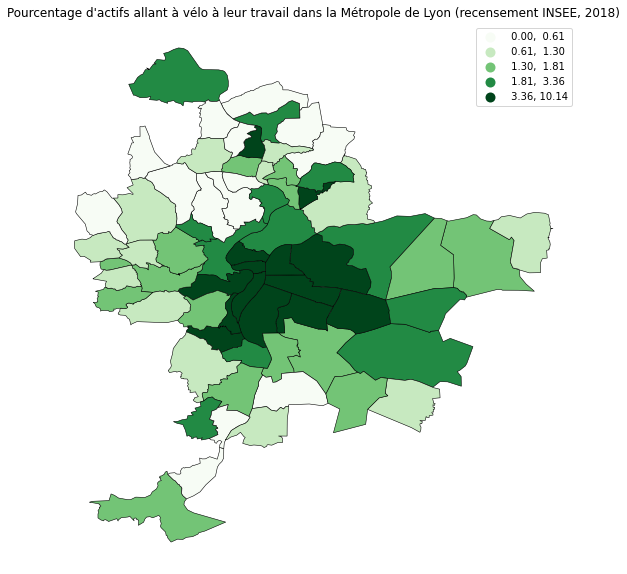

In [37]:
fig, ax = plt.subplots(figsize=(20,10))
geo_mopro.plot(ax=ax,column='p_velo',scheme='Quantiles',k=5,cmap="Greens",edgecolor="#000",linewidth=.55,legend=True)
ax.set_title("Pourcentage d'actifs allant à vélo à leur travail dans la Métropole de Lyon (recensement INSEE, 2018)")
ax.set_axis_off()
plt.savefig(r"images\\velo_ml18.jpg", dpi=300, bbox_inches = "tight")
plt.show();

...ou côté voitures :

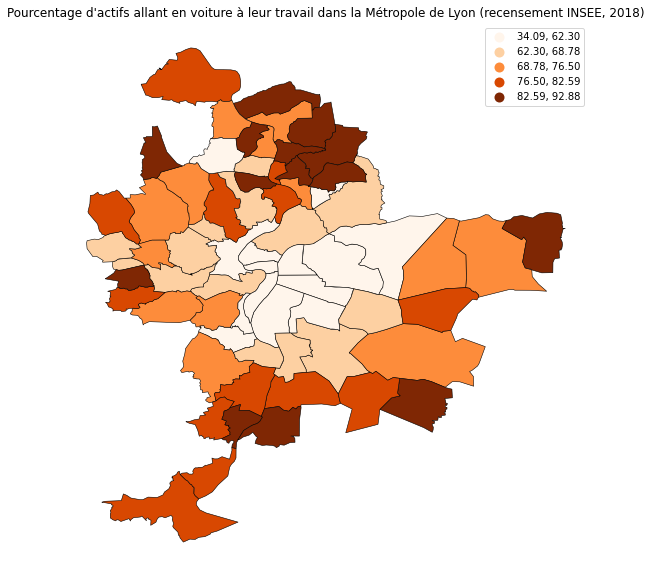

In [38]:
fig, ax = plt.subplots(figsize=(20,10))
geo_mopro.plot(ax=ax,column='p_voiture',scheme='Quantiles',k=5,cmap="Oranges",edgecolor="#000",linewidth=.55,legend=True)
ax.set_title("Pourcentage d'actifs allant en voiture à leur travail dans la Métropole de Lyon (recensement INSEE, 2018)")
ax.set_axis_off()
plt.savefig(r"images\\voiture_ml18.jpg", dpi=300, bbox_inches = "tight")
plt.show();

Et finalement enregistrer le fichier qui a vocation à être digéré par D3js :

In [39]:
geo_mopro.to_file(r"data\\mopro_ml18.json", driver="GeoJSON")

C:\Users\Rapha\AppData\Local\Programs\Python\Python310\lib\site-packages\geopandas\io\file.py:362: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  pd.Int64Index,


# Une carte d'évolution en points de pourcentage

Mon camarade lyonnais Bertrand Enjalbal a suggéré de partir de ce point de départ **pour comparer l'état des lieux de 2018 avec un recensement précédent**.

L'idée est de soustraire les pourcentages d'un recensement antérieur aux chiffres de 2018, pour obtenir l'évolution en points de pourcentage. Par exemple : "*sur cette commune ou cet arrondissement, on observe une augmentation de la pratique du vélo de x points de pourcentage*".

On va très largement s'inspirer de ce qui a été fait précédemment, en prenant en compte certaines spécifictés. La principale contrainte, c'est que **le vélo et les deux-roues motorisés étaient rassemblés avant 2018 dans une catégorie "deux roues"**.

On observe là un changement de doctrine dans la production des données, où une typologie la plus réduite possible s'est étoffée en distinguant polluant/non polluant. Il pourrait en être de même pour les transports en commun, en distinguant bus et train, etc. 

**Rappel utile : les données ne sont pas neutres, leur collecte, restitution, utilisation implique des choix qui font partie du job.**

Ce rappel fait, on va coder une fonction qui renverra pour 2018 l'exacte réplique de la DF mopro_ml18. Voici donc :

In [40]:
def transport_annee(annee:str,fformat:list,l_renommage:dict, col_filtre:list, l_filtre:list, remplacement:list, groupe_typo:str, corres_typo:dict,col_groupe:str, ajout_col:dict):
    """
        Cette fonction va effectuer des regroupements par typologie
    """
    print("Examen du fichier :","mopro\\FD_MOBPRO_"+annee+"."+fformat)
    DF_brute=pd.read_csv(r"mopro\\FD_MOBPRO_"+annee+"."+fformat,sep=";",low_memory=False)
    DF_brute.rename(columns=l_renommage,inplace=True)
    DF_brute=DF_brute[list(l_renommage.values())]
    for c in col_filtre:
        DF_brute=DF_brute[DF_brute[c].isin(l_filtre)].reset_index(drop=True)
    if len(remplacement)==3:
        DF_brute=remplacement_unique(DF_brute,remplacement[0],remplacement[1],remplacement[2])
    DF_brute[groupe_typo]=DF_brute[groupe_typo].astype(str)
    DF_brute[groupe_typo]=  DF_brute[groupe_typo].map(corres_typo)
    DF_brute[col_groupe]=DF_brute[col_groupe].astype(str)
    DF_brute[col_groupe]=DF_brute[col_groupe].str.replace(",",".")
    DF_brute[col_groupe]=DF_brute[col_groupe].astype(float)
    DF_brute=DF_brute.groupby(by=[col_filtre[0],groupe_typo]).sum().reset_index()
    DF_brute[col_groupe]=round(DF_brute[col_groupe])
    DF_brute[col_groupe]=DF_brute[col_groupe].astype(int)
    DF_brute.rename(columns={col_groupe:"effectif"},inplace=True)
    DF_brute=DF_brute[[col_filtre[0],groupe_typo,"effectif"]]
    l_index=[col_filtre[0]]
    for k in ajout_col.keys():
        l_index.append(k)
        DF_brute[k]=DF_brute[col_filtre[0]].map(ajout_col[k])
    pl_renommage=list(DF_brute[groupe_typo].unique())
    DF_finale=DF_brute.pivot_table(index=l_index, columns=[groupe_typo], values=["effectif"])
    DF_finale.columns=DF_finale.columns.map('_'.join)
    DF_finale=DF_finale.reset_index()
    DF_finale.fillna(0,inplace=True)
    col_d=["effectif_"+c for c in pl_renommage]
    for c in col_d:
        DF_finale[c]=DF_finale[c].astype(int)
    d_renommage={k:v for k,v in zip(col_d,pl_renommage)}
    DF_finale.rename(columns=d_renommage, inplace=True)
    ensemble=np.array([DF_finale[c] for c in [pl_renommage]])
    ensemble=[np.sum(ensemble[:,i]) for i in range(len(ensemble[0]))]
    DF_finale["ensemble"]=ensemble
    for c in pl_renommage:
        DF_finale["p_"+c]=round((DF_finale[c]/DF_finale["ensemble"])*100,2)
    return DF_finale

Et on va très vite tester ce qui a été fait en prenant en référence l'année 2018 :

In [41]:
test=transport_annee("2018","csv",reno_col,["insee_residence","insee_travail"],ml_insee,["arrondissement","insee_residence",["ZZZZZ"]],"mode_transport",corres_transport,"pindi",{"residence":dic_ml})
test.tail()

Examen du fichier : mopro\FD_MOBPRO_2018.csv


,insee_residence,residence,aucun,deux-roues motorisé,transports en commun,"voiture, camion ou fourgonnette",vélo,à pied,ensemble,p_aucun,p_deux-roues motorisé,p_transports en commun,"p_voiture, camion ou fourgonnette",p_vélo,p_à pied
62,69385,5e arrondissement de Lyon,9,132,1611,4083,213,112,6160,0.15,2.14,26.15,66.28,3.46,1.82
63,69386,6e arrondissement de Lyon,11,98,1954,2918,374,478,5833,0.19,1.68,33.50,50.03,6.41,8.19
64,69387,7e arrondissement de Lyon,9,134,4468,4988,774,51,10424,0.09,1.29,42.86,47.85,7.43,0.49
65,69388,8e arrondissement de Lyon,14,129,3765,6490,623,242,11263,0.12,1.15,33.43,57.62,5.53,2.15
66,69389,9e arrondissement de Lyon,1,98,2370,3804,142,123,6538,0.02,1.50,36.25,58.18,2.17,1.88


Vérifions maintenant que tout est conforme avec la précédente base de données (mopro_ml18) afin de s'assurer que rien ne dépasse.

Par exemple : est-ce que l'on a le même nombre d'ensemble à Montanay pour test et mopro_ml18 ? Réponse...

In [42]:
int(test[test["residence"]=="Montanay"]["ensemble"])==int(mopro_ml18[mopro_ml18["residence"]=="Montanay"]["ensemble"])

True

...oui ! Et on peut rapidement tester d'autres égalités, par exemple le pourcentage d'actifs ne prenant aucun véhicule à Rillieux-la-Pape :

In [43]:
float(test[test["residence"]=="Rillieux-la-Pape"]["p_aucun"])==float(mopro_ml18[mopro_ml18["residence"]=="Rillieux-la-Pape"]["p_aucun"])

True

La fonction marche, et on peut donc assigner une base de données centrée sur 2018 dans une nouvelle variable :

In [44]:
mopro_mldef=transport_annee("2018","csv",reno_col,["insee_residence","insee_travail"],ml_insee,["arrondissement","insee_residence",["ZZZZZ"]],"mode_transport",corres_transport,"pindi",{"residence":dic_ml})

Examen du fichier : mopro\FD_MOBPRO_2018.csv


**La doctrine de l'INSEE** concernant la typologie des transports **a changé entre 2008 et 2018** : l'Institut n'a commencé à comptabilisé les vélos à part qu'à partir de 2018.

Si l'on veut comparer 2018 à des chiffres d'une année précente, on doit donc **additionner les vélos et les deux-roues motorisés** dans une nouvelle colonne :

In [45]:
mopro_mldef["deux-roues"]=mopro_mldef["vélo"]+mopro_mldef["deux-roues motorisé"]
mopro_mldef.iloc[:5][["vélo","deux-roues motorisé","deux-roues"]]

,vélo,deux-roues motorisé,deux-roues
0,24,14,38
1,378,100,478
2,0,0,0
3,274,120,394
4,35,5,40


Addition bien mené, on peut désormais calculer le pourcentage de deux-roues à partir de cette nouvelle colonne :

In [46]:
mopro_mldef["p_deux-roues"]=round((mopro_mldef["deux-roues"]/mopro_mldef["ensemble"])*100,2)
mopro_mldef.iloc[:5][["p_vélo","p_deux-roues motorisé","p_deux-roues"]]

,p_vélo,p_deux-roues motorisé,p_deux-roues
0,3.65,2.13,5.78
1,3.80,1.01,4.81
2,0.00,0.00,0.00
3,3.11,1.36,4.48
4,3.01,0.43,3.44


Et on purge ce qui les colonnes consacrées aux vélos et aux deux-roues motorisés pour être tout à fait carrés :

In [47]:
mopro_mldef=mopro_mldef[[l for l in list(mopro_mldef.columns) if l not in ['deux-roues motorisé','p_deux-roues motorisé','vélo','p_vélo']]]
mopro_mldef.tail()

,insee_residence,residence,aucun,transports en commun,"voiture, camion ou fourgonnette",à pied,ensemble,p_aucun,p_transports en commun,"p_voiture, camion ou fourgonnette",p_à pied,deux-roues,p_deux-roues
62,69385,5e arrondissement de Lyon,9,1611,4083,112,6160,0.15,26.15,66.28,1.82,345,5.60
63,69386,6e arrondissement de Lyon,11,1954,2918,478,5833,0.19,33.50,50.03,8.19,472,8.09
64,69387,7e arrondissement de Lyon,9,4468,4988,51,10424,0.09,42.86,47.85,0.49,908,8.71
65,69388,8e arrondissement de Lyon,14,3765,6490,242,11263,0.12,33.43,57.62,2.15,752,6.68
66,69389,9e arrondissement de Lyon,1,2370,3804,123,6538,0.02,36.25,58.18,1.88,240,3.67


On va désormais se pencher sur 2008, et préparer avant le déclenchement de la fonction transport_annee un **nouveau dictionnaire de correspondance pour les différents types de transport** :

In [48]:
corres_trans08={"1":"aucun","2":"à pied","3":"deux roues","4":"voiture, camion ou fourgonnette","5":"transports en commun","Z":"sans objet"}

Désormais, on peut créer une nouvelle variable grâce à la fonction transport_annee, en mettant bien corres_trans08 en attribut :

In [49]:
mopro_ml08=transport_annee("2008","txt",reno_col,["insee_residence","insee_travail"],ml_insee,["arrondissement","insee_residence",["ZZZZZ"]],"mode_transport",corres_trans08,"pindi",{"residence":dic_ml})
mopro_ml08.tail()

Examen du fichier : mopro\FD_MOBPRO_2008.txt


,insee_residence,residence,aucun,deux roues,transports en commun,"voiture, camion ou fourgonnette",à pied,ensemble,p_aucun,p_deux roues,p_transports en commun,"p_voiture, camion ou fourgonnette",p_à pied
62,69385,5e arrondissement de Lyon,7,190,1525,4506,122,6350,0.11,2.99,24.02,70.96,1.92
63,69386,6e arrondissement de Lyon,9,278,1461,3355,415,5518,0.16,5.04,26.48,60.80,7.52
64,69387,7e arrondissement de Lyon,20,377,3182,5374,84,9037,0.22,4.17,35.21,59.47,0.93
65,69388,8e arrondissement de Lyon,21,331,2631,7080,195,10258,0.20,3.23,25.65,69.02,1.90
66,69389,9e arrondissement de Lyon,19,198,1796,4608,92,6713,0.28,2.95,26.75,68.64,1.37


Dès lors, **on peut très vite dégager des tendances à partir de ces DF**. Par exemple, le Top 5 des communes/arrondissements de Lyon dont les actifs se déplacent à vélo en 2008 :

In [50]:
mopro_ml08=mopro_ml08.sort_values(by="p_deux roues",ascending=False)
mopro_ml08.iloc[:5]

,insee_residence,residence,aucun,deux roues,transports en commun,"voiture, camion ou fourgonnette",à pied,ensemble,p_aucun,p_deux roues,p_transports en commun,"p_voiture, camion ou fourgonnette",p_à pied
60,69383,3e arrondissement de Lyon,31,692,3338,7779,440,12280,0.25,5.64,27.18,63.35,3.58
0,69003,Albigny-sur-Saône,28,36,56,517,48,685,4.09,5.26,8.18,75.47,7.01
28,69163,Quincieux,60,36,24,544,36,700,8.57,5.14,3.43,77.71,5.14
63,69386,6e arrondissement de Lyon,9,278,1461,3355,415,5518,0.16,5.04,26.48,60.80,7.52
58,69381,1er arrondissement de Lyon,0,160,1662,1489,74,3385,0.00,4.73,49.10,43.99,2.19


Et regarder si des choses se recocupent avec 2018 :

In [51]:
mopro_mldef=mopro_mldef.sort_values(by="p_deux-roues",ascending=False)
mopro_mldef.iloc[:5]

,insee_residence,residence,aucun,transports en commun,"voiture, camion ou fourgonnette",à pied,ensemble,p_aucun,p_transports en commun,"p_voiture, camion ou fourgonnette",p_à pied,deux-roues,p_deux-roues
58,69381,1er arrondissement de Lyon,0,1639,1082,31,3174,0.00,51.64,34.09,0.98,422,13.30
60,69383,3e arrondissement de Lyon,11,5245,6619,510,13790,0.08,38.03,48.00,3.70,1405,10.19
61,69384,4e arrondissement de Lyon,3,1276,2315,131,4137,0.07,30.84,55.96,3.17,412,9.96
64,69387,7e arrondissement de Lyon,9,4468,4988,51,10424,0.09,42.86,47.85,0.49,908,8.71
63,69386,6e arrondissement de Lyon,11,1954,2918,478,5833,0.19,33.50,50.03,8.19,472,8.09


On va préparer la fusion entre les deux bases à venir en harmonisant les colonnes et en vérifiant qu'on trouve bien les mêmes noms pour chaque DataFrame :

In [52]:
evol_mopro=mopro_mldef.copy()
evol_mopro.rename(columns={"deux-roues":"deux roues","p_deux-roues":"p_deux roues"}, inplace=True)
set(list(evol_mopro.columns))==set(list(mopro_ml08.columns))

True

On va tout de même être obligé de distinguer une des deux années afin d'être sûr de soustraire 2008 à 2018, et pas l'inverse. Cela va se passer avec un dictionnaire :

In [53]:
dic_evol={"p_"+k:"p_"+k+"_018" for k in ["aucun","transports en commun","voiture, camion ou fourgonnette","à pied","deux roues"]}
dic_evol

{'p_aucun': 'p_aucun_018',
 'p_transports en commun': 'p_transports en commun_018',
 'p_voiture, camion ou fourgonnette': 'p_voiture, camion ou fourgonnette_018',
 'p_à pied': 'p_à pied_018',
 'p_deux roues': 'p_deux roues_018'}

Et ce dictionnaire va servir à renommer les colonnes, avant de fusionner evol_mopro à mopro_ml08 en visant "insee_residence" comme champ commun :

In [54]:
evol_mopro.rename(columns=dic_evol, inplace=True)
evol_mopro=evol_mopro.merge(mopro_ml08, on="insee_residence")
evol_mopro.tail()

,insee_residence,residence_x,aucun_x,transports en commun_x,"voiture, camion ou fourgonnette_x",à pied_x,ensemble_x,p_aucun_018,p_transports en commun_018,"p_voiture, camion ou fourgonnette_018",...,deux roues_y,transports en commun_y,"voiture, camion ou fourgonnette_y",à pied_y,ensemble_y,p_aucun,p_deux roues,p_transports en commun,"p_voiture, camion ou fourgonnette",p_à pied
62,69153,Poleymieux-au-Mont-d'Or,67,48,285,79,483,13.87,9.94,59.01,...,4,52,260,93,443,7.67,0.90,11.74,58.69,20.99
63,69117,Lissieu,40,20,614,10,689,5.81,2.90,89.11,...,8,16,635,20,720,5.69,1.11,2.22,88.19,2.78
64,69260,Vernaison,50,55,936,56,1102,4.54,4.99,84.94,...,20,76,1065,76,1273,2.83,1.57,5.97,83.66,5.97
65,69071,Curis-au-Mont-d'Or,5,20,293,5,323,1.55,6.19,90.71,...,0,11,234,4,275,9.45,0.00,4.00,85.09,1.45
66,69033,Cailloux-sur-Fontaines,44,19,642,39,744,5.91,2.55,86.29,...,23,27,584,8,665,3.46,3.46,4.06,87.82,1.20


Et maintenant on va créer à la volée de nouvelles colonnes en soustrayant à chaque fois, pour un même type de transport, les pourcentages de 2008 à ceux de 2018. **Le résultat sera donc l'évolution en points de pourcentage de chaque transport** :

In [55]:
for mt in ["aucun","transports en commun","voiture, camion ou fourgonnette","à pied","deux roues"]:
    evol_mopro["evol_"+mt]=evol_mopro["p_"+mt+"_018"]-evol_mopro["p_"+mt]
evol_mopro=evol_mopro[["residence_x","insee_residence","evol_aucun","evol_transports en commun","evol_deux roues","evol_voiture, camion ou fourgonnette","evol_à pied"]]
evol_mopro.rename(columns={"residence_x":"residence"},inplace=True)
evol_mopro.tail()

,residence,insee_residence,evol_aucun,evol_transports en commun,evol_deux roues,"evol_voiture, camion ou fourgonnette",evol_à pied
62,Poleymieux-au-Mont-d'Or,69153,6.20,-1.80,-0.07,0.32,-4.63
63,Lissieu,69117,0.12,0.68,-0.38,0.92,-1.33
64,Vernaison,69260,1.71,-0.98,-1.12,1.28,-0.89
65,Curis-au-Mont-d'Or,69071,-7.90,2.19,0.00,5.62,0.10
66,Cailloux-sur-Fontaines,69033,2.45,-1.51,-3.46,-1.53,4.04


On peut vérifier les plus fortes progressions pour les deux-roues comme ceci :

In [56]:
evol_mopro=evol_mopro.sort_values(by="evol_deux roues",ascending=False)
evol_mopro.iloc[:5]

,residence,insee_residence,evol_aucun,evol_transports en commun,evol_deux roues,"evol_voiture, camion ou fourgonnette",evol_à pied
0,1er arrondissement de Lyon,69381,0.00,2.54,8.57,-9.90,-1.21
2,4e arrondissement de Lyon,69384,0.00,4.16,5.27,-9.67,0.24
8,La Mulatière,69142,-1.34,3.53,5.08,-5.55,-1.71
1,3e arrondissement de Lyon,69383,-0.17,10.85,4.55,-15.35,0.12
3,7e arrondissement de Lyon,69387,-0.13,7.65,4.54,-11.62,-0.44


La suite est attendue : on fait une fusion avec le fichier géographique déjà utilisé précédemment, et on le retransforme en GeoDataFrame :

In [57]:
geo_evmopro=evol_mopro.merge(communes_mlyon, left_on="insee_residence", right_on="insee")
geo_evmopro=gpd.GeoDataFrame(geo_evmopro, geometry=geo_evmopro["geometry"])
geo_evmopro.tail()

,residence,insee_residence,evol_aucun,evol_transports en commun,evol_deux roues,"evol_voiture, camion ou fourgonnette",evol_à pied,insee,geometry
62,Quincieux,69163,0.03,-0.20,-1.91,4.01,-1.91,69163,"MULTIPOLYGON (((4.73386 45.91124, 4.73770 45.9..."
63,Marcy-l'Étoile,69127,3.82,2.59,-1.96,-1.55,-2.90,69127,"MULTIPOLYGON (((4.69174 45.78845, 4.69213 45.7..."
64,Saint-Germain-au-Mont-d'Or,69207,0.67,3.69,-2.16,-0.98,-1.23,69207,"MULTIPOLYGON (((4.78729 45.89299, 4.78867 45.8..."
65,Feyzin,69276,-0.33,3.67,-2.38,1.40,-2.35,69276,"MULTIPOLYGON (((4.82932 45.66034, 4.83126 45.6..."
66,Cailloux-sur-Fontaines,69033,2.45,-1.51,-3.46,-1.53,4.04,69033,"MULTIPOLYGON (((4.85449 45.85609, 4.85624 45.8..."


Des visualisations centrées sur différents types de transports sont facilement réalisable grâce à matplotlib. Par exemple sur l'évolution de l'usage des deux-roues...

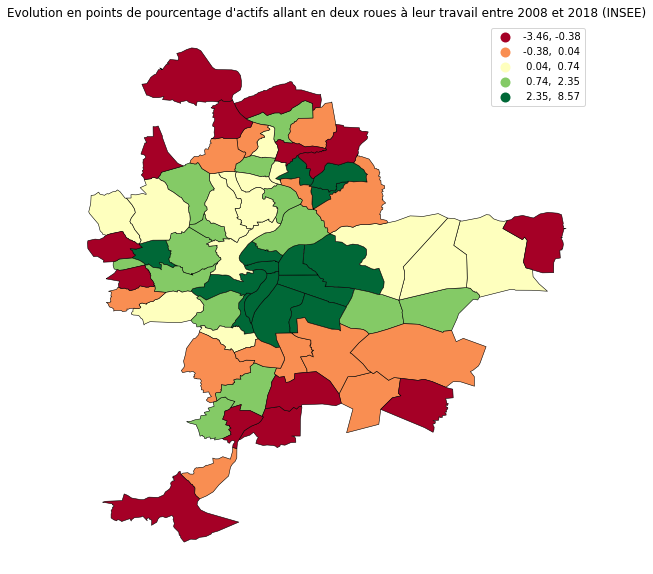

In [58]:
fig, ax = plt.subplots(figsize=(20,10))
geo_evmopro.plot(ax=ax,column='evol_deux roues',scheme='Quantiles',k=5,cmap="RdYlGn",edgecolor="#000",linewidth=.55,legend=True)
ax.set_title("Evolution en points de pourcentage d'actifs allant en deux roues à leur travail entre 2008 et 2018 (INSEE)")
ax.set_axis_off()
plt.savefig(r"images\\evol_ml_deur.jpg", dpi=300, bbox_inches = "tight")
plt.show();

...comme sur celui de la voiture :

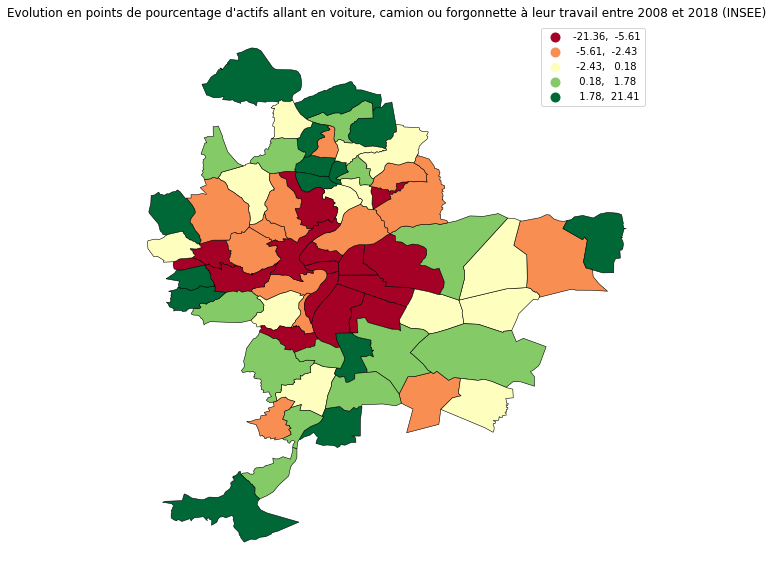

In [59]:
fig, ax = plt.subplots(figsize=(20,10))
geo_evmopro.plot(ax=ax,column='evol_voiture, camion ou fourgonnette',scheme='Quantiles',k=5,cmap="RdYlGn",edgecolor="#000",linewidth=.55,legend=True)
ax.set_title("Evolution en points de pourcentage d'actifs allant en voiture, camion ou forgonnette à leur travail entre 2008 et 2018 (INSEE)")
ax.set_axis_off()
plt.savefig(r"images\\evol_ml_voiture.jpg", dpi=300, bbox_inches = "tight")
plt.show();

Et on peut réserver le résultat dans un GeoJSON digérable par D3js :

In [60]:
geo_evmopro.to_file(r"data\\evol_mopro_ml.json", driver="GeoJSON")

C:\Users\Rapha\AppData\Local\Programs\Python\Python310\lib\site-packages\geopandas\io\file.py:362: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  pd.Int64Index,


# CSP par mode de transport

Dernier fichier à préparer : les modes de transports selon les Catégories Socio-Professionnelles (CSP). Le principe est grosso modo le même que précédemment, et on va tout de suite factoriser les opérations utiles :

In [61]:
def col_tranches(n_df:str,l_renommage:dict, col_filtre:list, l_filtre:list, col_cible:str, corres_col:dict,tranches:str,corres_tranche:dict,col_chiffre:str,n_fichier:str):
    """
        Cette fonction va cibler une colonne et éclater une colonne enfant en autant de colonnes. L'ensemble est réparti entre effectifs brut et pourcentage, puis enregistré en json.
        Exemple : connaître le découpage par CSP de chaque mode de transport.
    """
    dict_final={}
    DF_brute=pd.read_csv(n_df,sep=";",low_memory=False)
    DF_brute.rename(columns=l_renommage,inplace=True)
    DF_brute=DF_brute[list(l_renommage.values())]
    for c in col_filtre:
        DF_brute=DF_brute[DF_brute[c].isin(l_filtre)].reset_index(drop=True)
    for col, cor in zip([col_cible, tranches],[corres_col,corres_tranche]):
        DF_brute[col]=DF_brute[col].astype(str)
        DF_brute[col]=DF_brute[col].map(cor)
    DF_brute=DF_brute[[col_cible, tranches,col_chiffre]]
    DF_trans=DF_brute.groupby(by=[col_cible, tranches]).sum().reset_index()
    DF_trans[col_chiffre]=round(DF_trans[col_chiffre])
    DF_trans[col_chiffre]=DF_trans[col_chiffre].astype(int)
    for m_t in list(DF_trans[col_cible].unique()):
        dict_local={}
        DF_tampon=DF_trans.copy()
        DF_tampon=DF_tampon[DF_tampon[col_cible]==m_t]
        DF_tampon.rename(columns={col_chiffre:"v"}, inplace=True)
        DF_tampon["p"]=round((DF_tampon["v"]/DF_tampon["v"].sum())*100,2)
        for i,l in DF_tampon.iterrows():
            dict_local[l[tranches]]={"v":l["v"],"p":l["p"]}
        dict_final[m_t]=dict_local
    DF_finale=pd.DataFrame.from_dict(dict_final)
    for c in DF_finale.columns:
        DF_finale[c]=DF_finale[c].apply(lambda x: x if x == x else {"v":0,"p":0.0})
    DF_finale.to_json(n_fichier)
    print("Fichier prêt")

Plus qu'à créer un dictionnaire de correspondance centré sur les CSP :

In [62]:
corres_csp={"1":"agriculteur","2":"artisan, commerçant ou chef d'entreprise","3":"cadre ou profession intellectuelle supérieure","4":"profession intermédiaire","5":"employé","6":"ouvrier","7":"retraité","8":"sans activité professionnelle"}

Et à dérouler la fonction pour ensuite enregistrer le fichier :

In [63]:
col_tranches(r"mopro\\FD_MOBPRO_2018.csv",reno_col,["insee_residence","insee_travail"],ml_insee,"csp",corres_csp,"mode_transport",corres_transport,"pindi","data\\trans_csp.json")

Fichier prêt
